In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 1. Configuration
ANNOTATION_FILE = "CULane/culane_train_annotations.json"   
BATCH_SIZE = 8                                      
SUBSET_SIZE = 1000                                  
IMG_SIZE = (256, 256) 

In [ ]:
# 2. Lane Dataset
class LaneDataset(Dataset):
    def __init__(self, annotations, transform=None, mask_transform=None):
        self.annotations = annotations
        self.transform = transform if transform else transforms.ToTensor()
        self.mask_transform = mask_transform if mask_transform else transforms.ToTensor()

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_path, mask_path = ann["image"], ann["mask"]

        try:
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
        except Exception as e:
            raise RuntimeError(f"❌ Failed to load {img_path} or {mask_path}: {e}")

        # Apply transforms
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Binarize mask (lane = 1, background = 0)
        mask = torch.where(mask > 0, 1.0, 0.0)

        return image, mask


In [ ]:
# 3. Load Annotations
print(f"📂 Loading annotations from {ANNOTATION_FILE}...")
with open(ANNOTATION_FILE, "r") as f:
    all_culane_annotations = json.load(f)

print(f"✅ Found {len(all_culane_annotations)} total samples.")
verification_subset = all_culane_annotations[:SUBSET_SIZE]
print(f"🔎 Using subset of {len(verification_subset)} samples for verification.")


📂 Loading annotations from CULane/culane_train_annotations.json...
✅ Found 88880 total samples.
🔎 Using subset of 1000 samples for verification.


In [ ]:
# 4. Define Transforms
image_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])


In [ ]:
# 5. DataLoader
dataset = LaneDataset(
    annotations=verification_subset,
    transform=image_transform,
    mask_transform=mask_transform
)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)



🖼️ Displaying one batch of 8 samples...


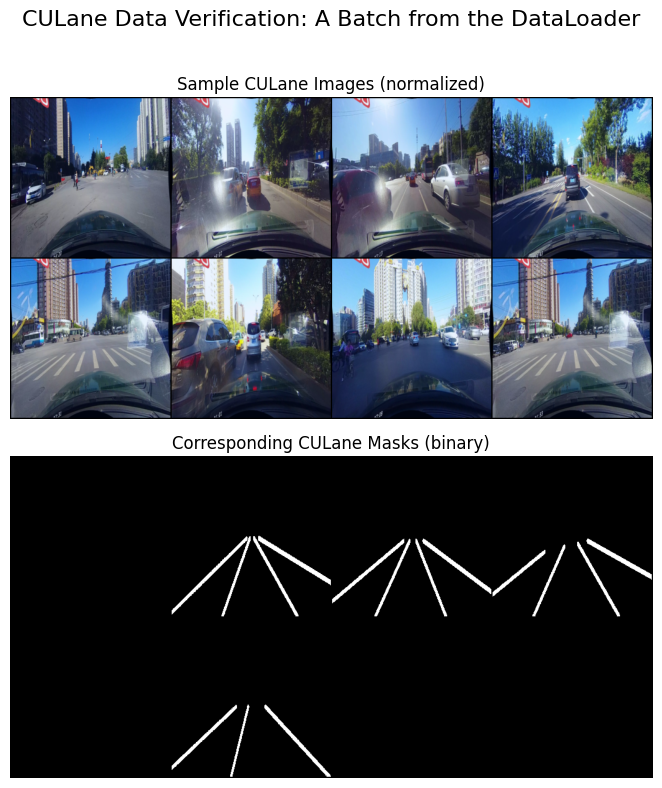

In [ ]:
# 6. Visualization
print(f"\n🖼️ Displaying one batch of {BATCH_SIZE} samples...")

images, masks = next(iter(loader))

# Make grids
img_grid = make_grid(images, nrow=4, normalize=True, scale_each=True)
mask_grid = make_grid(masks, nrow=4, normalize=False)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
fig.suptitle("CULane Data Verification: A Batch from the DataLoader", fontsize=16)

ax[0].imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
ax[0].set_title("Sample CULane Images (normalized)")
ax[0].axis("off")

ax[1].imshow(np.transpose(mask_grid.numpy(), (1, 2, 0)), cmap="gray")
ax[1].set_title("Corresponding CULane Masks (binary)")
ax[1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()